# Mathematical Art - 10,000 Cirlces

Author Nick Brownlie

The code in this notebook allows the recreation of mathematical artwork created by Hamid Naderi Yeganeh

The original work can be found at https://blogs.scientificamerican.com/guest-blog/making-mathematical-art/

This notebook will recreate the 10,000 circles design from the aforementioned article and does so by plotting the centre coordinates X(k) and Y(k) with a radius of R(k), where k ranges from 1-10000

The mathematical formulas for this can be seen below:

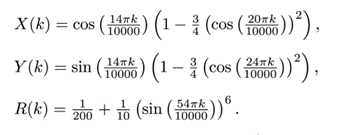

This is a hardware accelerated model designed to be run on the PYNQ-Z2 board

Begin by importing the required libraries

In [1]:
import matplotlib.pyplot as plt
import math

Python interprets the output from the axi-lite interface as 32 bit unsigned numbers so the following function converts these to signed binary numbers, with 1 signed bit and 31 fractional bits

In [2]:
def to_signedfract(val,b):
    val_str = (bin(val)[2:]).zfill(b);
    return -1*int(val_str[0]) + int(val_str[1:], 2) / 2.** (b-1)

The programmable logic section of the the Pynq-Z2 board carries out the computational analysis of the above equations 
determining the centre co-ordinates (X,Y) and radius R with respect to the value of k.

System Generator was used to create the IP core and IP interface document and an image of the block diagram used is shown below.

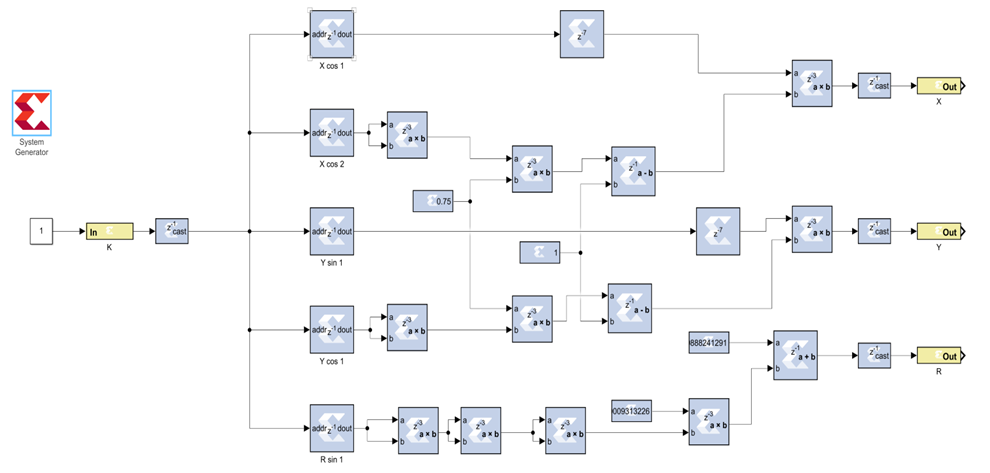

For this particular design each sin and cosine function was given its own lookup table and addressed with the input value of k. The values are then manipulated according to the previously given equations using various multiplication, add/subtract and constant value blocks. Delay blocks were also used to minimise any difference in path length bewtween the inputs.

The IP created in system generator was imported to Vivado suite and used to create a custom overlay for the Pynq-Z2 board. The block diagram from this is shown below.

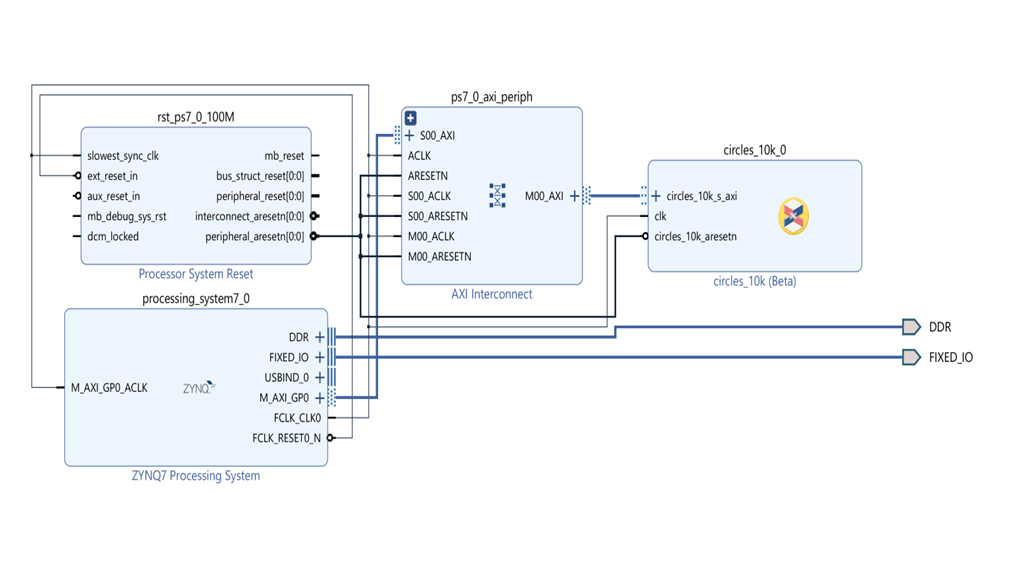

Vivado suite was used to generate the handoff file and bit file for the above diagram and have been included in this jupyter folder.

The below code implements and custom driver for the IP.

In [3]:
from pynq import DefaultIP
class AddDriver(DefaultIP):
    def __init__(self, description):
        super().__init__(description=description)
    bindto = ['User_Company:SysGen:circles_10k:1.0']
    def getX(self, k):
        self.write(0x00, k) 
        return to_signedfract(self.read(0x08),32)
    
    def getY(self, k):
        self.write(0x00, k) 
        return to_signedfract(self.read(0xC),32) 
    
    def getR(self, k):
        self.write(0x00, k) 
        return to_signedfract(self.read(0x04),32)
    
    def getValues(self, k):
        self.write(0x00, k)
        return to_signedfract(self.read(0x08),32),to_signedfract(self.read(0xC),32),to_signedfract(self.read(0x04),32)

The custom overlay is then imported

In [4]:
from pynq import Overlay
ol = Overlay("design_1_wrapper.bit");

In [5]:
circles_10K = ol.circles_10k_0

The colours used in the design change as the value of k changes with each loop iteration. To make the code more interactive a colour chart has been included below. Simply change the choose the colours you would like too see in the design and replace the existing colour codes with your own in the below function. 

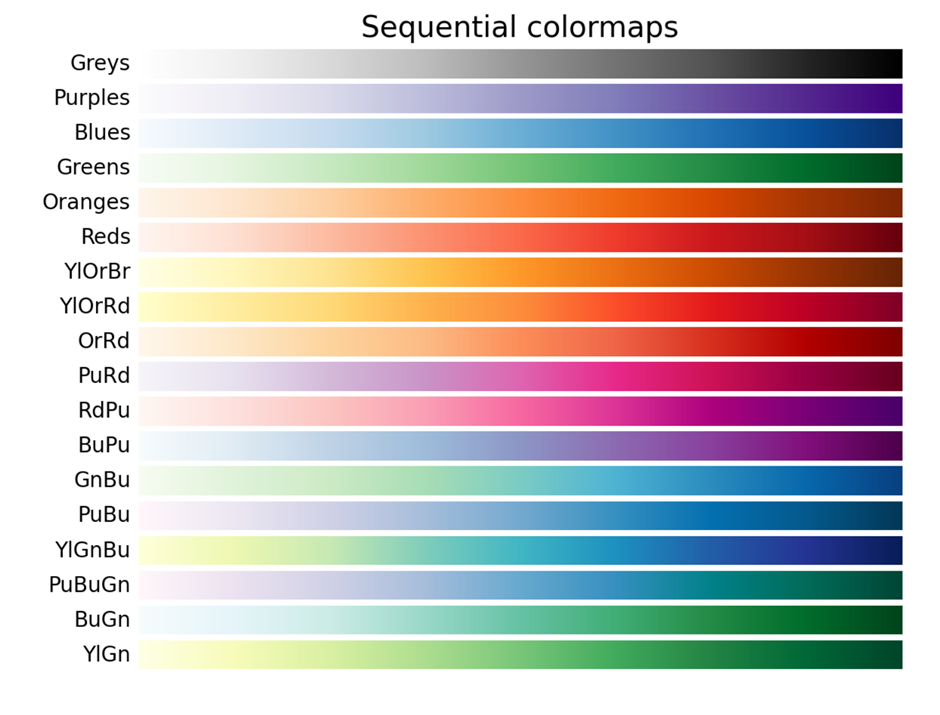

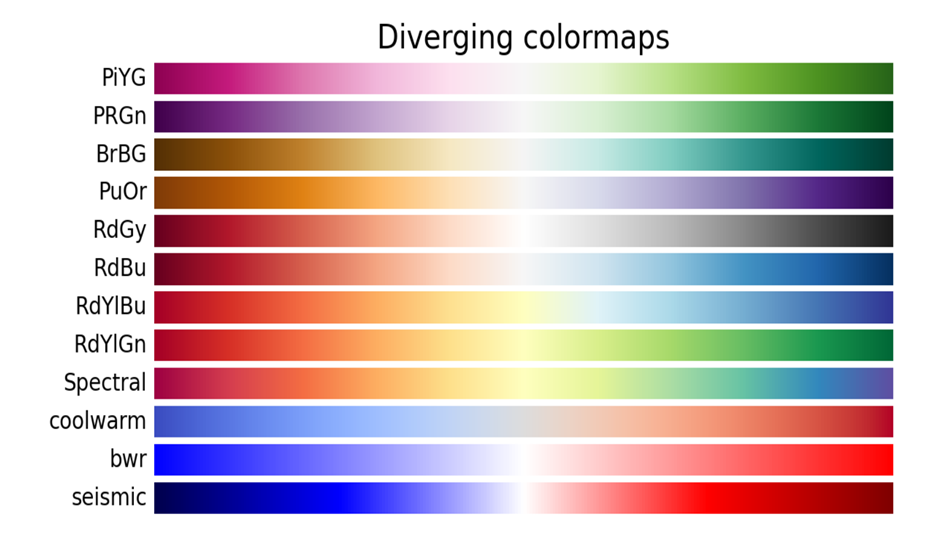

In [6]:
def plot_values():
    figure, axes = plt.subplots(dpi = 600)
    X, Y, R = 0, 0, 0
    for i in range(1,10000):
        
        if i <= 5000:
            #COLOUR CODE CHANGE
            colour_grad = plt.cm.RdBu (i/5000)
        else:
            #COLOUR CODE CHANGE
            colour_grad = plt.cm.Spectral((i-5000)/5000)
            
        X,Y,R = circles_10K.getValues(i);
        axes.add_artist(plt.Circle((X, Y), R, fill=False, linewidth=0.1, color=colour_grad))
    plt.xlim(-1.1, 1.1)
    plt.ylim(-1.1, 1.1)
    axes.axis('off')
    axes.set_aspect(1)
    plt.show()  
    return

Lastly, run the below function to generate your colourful artwork. The processor of the Pynq-Z2 finds it a bit of struggle 
to plot so many circles in a short space of time so this process will take approx 5 mins to complete. 

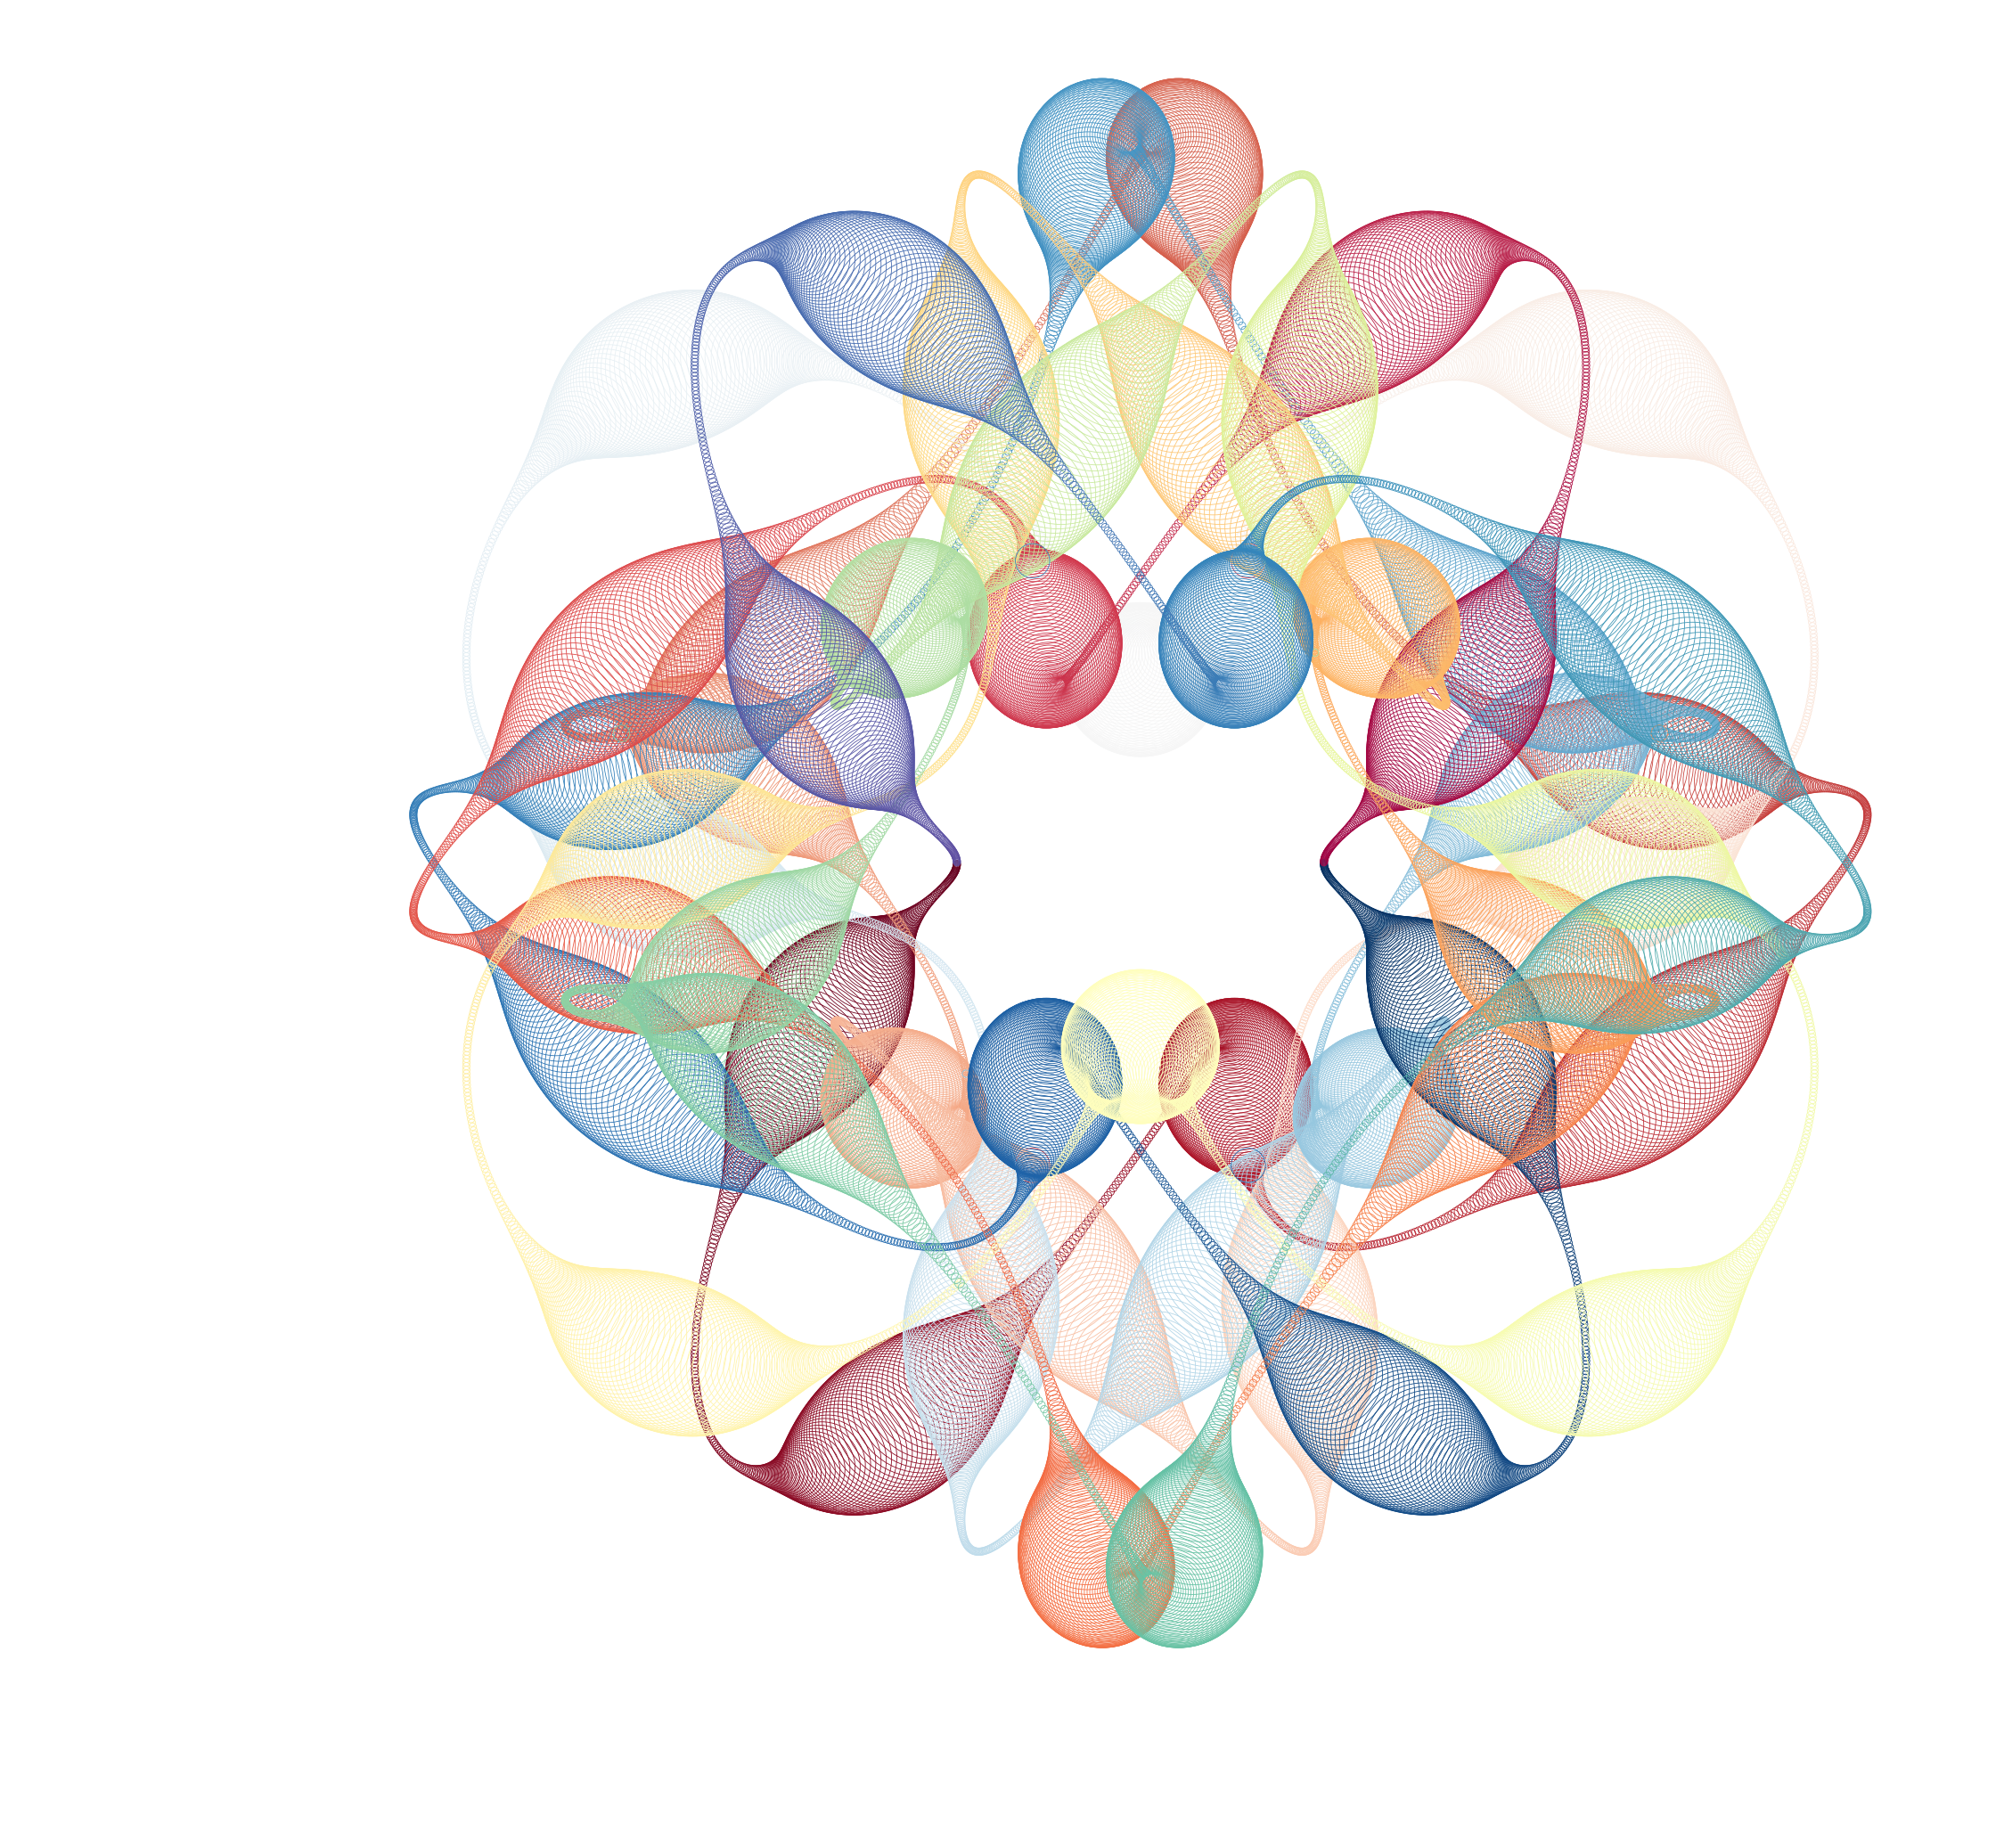

In [7]:
plot_values();

The code below demonstrates that although the overall time to produce the image is around 5 mins. The time for the hardware to carry out the calculations if very quick.

In [8]:
import time
start_time = time.time()
#Programmable Logic Speed Test
for i in range(1,10000):
    L,M,N =0,0,0
    L,M,N = circles_10K.getValues(i);
end_time = time.time()   
duration = end_time - start_time
print("Function took", duration, "seconds to run.")

Function took 2.3000524044036865 seconds to run.
